<!-- TODO: Self-organizing maps and hexagonal grids (Kohonen 1982; Huysmans et al.  2006a; Seret et al. 2012). A SOM -->
<!-- TODO: DBScan, TSNE, <https://speakerdeck.com/lmcinnes/umap-uniform-manifold-approximation-and-projection-for-dimension-reduction> -->
<!-- TODO: Good overview and connections to optimization <https://www.youtube.com/watch>?time_continue=1&v=9iol3Lk6kyU -->
<!-- TODO:    - Generalized_low_rank_models_Udell -->

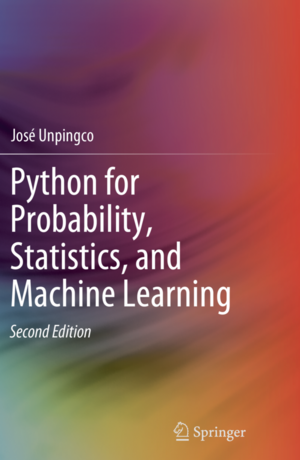

In [3]:
from IPython.display import Image
Image('../../Python_probability_statistics_machine_learning_2E.png',width=200)

In [4]:
%matplotlib inline

from matplotlib.pylab import subplots
import numpy as np
from sklearn.datasets import make_blobs

Clustering is the simplest member of a family of machine learning methods that
do not require supervision to learn from data. Unsupervised methods
have training sets that do not have a target variable. These unsupervised learning
methods rely upon a meaningful metric to group data into 
clusters. This makes it an excellent exploratory data analysis
method because there are very few assumptions built into the method itself.
In this section, we focus on the popular K-means clustering method that is
available in Scikit-learn.

Let's manufacture some data to get going with `make_blobs` from Scikit-learn.
[Figure](#fig:clustering_001) shows some example clusters in two dimensions.
Clustering methods work by minimizing the following objective function,

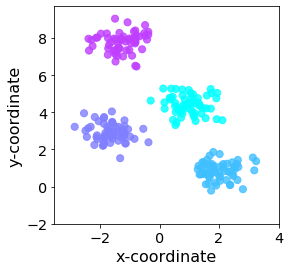

In [5]:
from sklearn.datasets import make_blobs
fig,ax=subplots()
X, y = make_blobs(n_samples=300, centers=5,
                  random_state=0, cluster_std=0.5)
_=ax.scatter(X[:,0],X[:,1],c=y,s=50,cmap='cool',alpha=.8);
_=ax.set_xlabel('x-coordinate',fontsize=16)
_=ax.set_ylabel('y-coordinate',fontsize=16)
_=ax.axis(xmax=4,ymin=-2)
ax.tick_params(labelsize='x-large')
ax.set_aspect(1/1.6)
fig.savefig('fig-machine_learning/clustering_001.png')

<!-- dom:FIGURE: [fig-machine_learning/clustering_001.png, width=500 frac=0.85]  The four clusters are pretty easy to see in this example and we want clustering methods to determine the extent and number of such clusters automatically.  <div id="fig:clustering_001"></div> -->
<!-- begin figure -->
<div id="fig:clustering_001"></div>

<p>The four clusters are pretty easy to see in this example and we want clustering methods to determine the extent and number of such clusters automatically.</p>
<img src="fig-machine_learning/clustering_001.png" width=300>

<!-- end figure -->

$$
J = \sum_k \sum_i \Vert \mathbf{x}_i-\mathbf{\mu}_k \Vert^2
$$

 The *distortion* for the $k^{th}$ cluster is the summand,

$$
\sum_i \Vert \mathbf{x}_i - \mathbf{ \mu }_k \Vert^2
$$

 Thus, clustering algorithms work to minimize this by adjusting the
centers of the individual clusters, $\mu_k$. Intuitively, each $\mu_k$ is the
*center of mass* of the points in the cloud.  The Euclidean distance is
the typical metric used for this,

$$
\Vert \mathbf{ x } \Vert^2 = \sum x_i^2
$$

 There are many clever algorithms that can solve this problem for
the best $\mu_k$ cluster-centers. The K-means algorithm starts with a
user-specified number of $K$ clusters to optimize over.  This is implemented in
Scikit-learn with the `KMeans` object that follows the usual fitting
conventions in Scikit-learn,

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

 where we  have chosen $K=4$. How do we choose the value of
$K$?  This is the eternal question of generalization versus
approximation --- too many clusters provide great approximation but
bad generalization. One way to approach this problem is to compute the
mean distortion for increasingly larger values of $K$ until it no
longer makes sense. To do this, we want to take every data point and
compare it to the centers of all the clusters.  Then, take the
smallest value of this across all clusters and average those. This
gives us an idea of the overall mean performance for the $K$ clusters.
The following code computes this explicitly.

**Programming Tip.**

The `cdist` function from Scipy computes all the pairwise
differences between the two input collections according to the
specified metric.

In [7]:
from scipy.spatial.distance import cdist
m_distortions=[]
for k in range(1,7):
    kmeans = KMeans(n_clusters=k)
    _=kmeans.fit(X)
    tmp=cdist(X,kmeans.cluster_centers_,'euclidean')
    m_distortions.append(sum(np.min(tmp,axis=1))/X.shape[0])

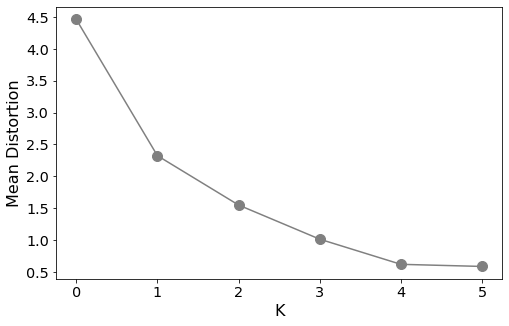

In [8]:
fig,ax=subplots()
fig.set_size_inches((8,5))
_=ax.plot(m_distortions,'-o',ms=10,color='gray')
_=ax.set_xlabel('K',fontsize=16)
_=ax.set_ylabel('Mean Distortion',fontsize=16)
ax.tick_params(labelsize='x-large')
# ax.set_aspect(1/1.6)
fig.savefig('fig-machine_learning/clustering_002.png')

<!-- dom:FIGURE: [fig-machine_learning/clustering_002.png, width=500 frac=0.75] The Mean Distortion shows that there is a diminishing value in using more clusters.  <div id="fig:clustering_002"></div> -->
<!-- begin figure -->
<div id="fig:clustering_002"></div>

<p>The Mean Distortion shows that there is a diminishing value in using more clusters.</p>
<img src="fig-machine_learning/clustering_002.png" width=500>

<!-- end figure -->


 Note that code above uses the `cluster_centers_`, which are
estimated from K-means algorithm. The resulting [Figure](#fig:clustering_002) shows the point of diminishing returns for
added additional clusters.


Another figure-of-merit is the silhouette coefficient, which measures
how compact and separated the individual clusters are. To  compute the
silhouette coefficient, we need to compute the mean intra-cluster
distance for each sample ($a_i$) and the mean distance to the next
nearest cluster ($b_i$). Then, the silhouette coefficient for the
$i^{th}$ sample is

$$
\texttt{sc}_i = \frac{b_i-a_i}{\max(a_i,b_i)}
$$

 The mean silhouette coefficient is just the mean of all these values
over all the samples.  The best value is one and the worst is negative one,
with values near zero indicating overlapping clusters and negative values
showing that samples have been incorrectly assigned to the wrong cluster.  This
figure-of-merit is implemented in Scikit-learn as in the following,

In [9]:
from sklearn.metrics import silhouette_score

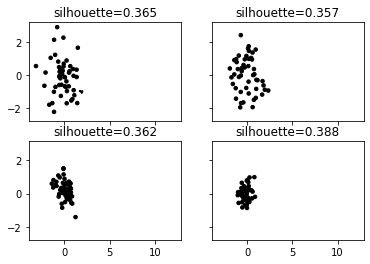

In [10]:
def scatter_fit(X,y,ax):
    _=kmeans.fit(X)
    _=ax.scatter(X[:,0],X[:,1],c=y,s=50,cmap='gray',marker='.')
    _=ax.set_title('silhouette={:.3f}'.format(silhouette_score(X,kmeans.labels_)))

fig,axs = subplots(2,2,sharex=True,sharey=True)
np.random.seed(12)
ax=axs[0,0]
X,y=make_blobs(centers=[[0,0],[3,0]],n_samples=100)
scatter_fit(X,y,ax)
ax=axs[0,1]
X,y=make_blobs(centers=[[0,0],[10,0]],n_samples=100)
scatter_fit(X,y,ax)
ax=axs[1,0]
X,y=make_blobs(centers=[[0,0],[3,0]],n_samples=100,cluster_std=[.5,.5])
scatter_fit(X,y,ax)
ax=axs[1,1]
X,y=make_blobs(centers=[[0,0],[10,0]],n_samples=100,cluster_std=[.5,.5])
scatter_fit(X,y,ax)
fig.savefig('fig-machine_learning/clustering_003.png')

 [Figure](#fig:clustering_004) shows how the silhouette coefficient varies
as the clusters become more dispersed and/or closer together.

<!-- dom:FIGURE: [fig-machine_learning/clustering_003.png, width=500 frac=0.85]  The shows how the silhouette coefficient varies as the clusters move closer and become more compact. <div id="fig:clustering_003"></div> -->
<!-- begin figure -->
<div id="fig:clustering_003"></div>

<p>The shows how the silhouette coefficient varies as the clusters move closer and become more compact.</p>
<img src="fig-machine_learning/clustering_003.png" width=500>

<!-- end figure -->


K-means is easy to understand  and to implement, but can be sensitive
to the initial choice of cluster-centers. The default initialization
method in Scikit-learn uses a very effective and clever randomization
to come up with the initial cluster-centers. Nonetheless, to see why
initialization can cause instability with K-means, consider the
following [Figure](#fig:clustering_004), In [Figure](#fig:clustering_004), there are two large clusters on the left and
a very sparse cluster on the far right. The large circles at the
centers are the cluster-centers that K-means found. Given $K=2$, how
should the cluster-centers be chosen? Intuitively, the first two
clusters should have their own cluster-center somewhere between them
and the sparse cluster on the right should have its own cluster-center [^kmeans].  
Why isn't this happening?

[^kmeans]: Note that we are using the `init=random` keyword argument for this
example in order to illustrate this.

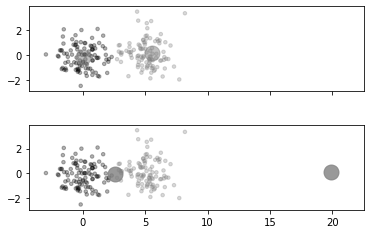

In [11]:
X,y = make_blobs(centers=[[0,0],[5,0]],random_state=100,n_samples=200)
Xx,yx=make_blobs(centers=[[20,0]],random_state=100,n_samples=3)
X=np.vstack([X,Xx])
y=np.hstack([y,yx+2])

fig,axs=subplots(2,1,sharex=True,sharey=True)
ax=axs[0]
_=ax.scatter(X[:,0],X[:,1],c=y,s=50,cmap='gray',marker='.',alpha=.3);
_=kmeans = KMeans(n_clusters=2,random_state=123,init='random')
_=kmeans.fit(X)
_=ax.set_aspect(1)
_=ax.plot(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],'o',color='gray',ms=15,alpha=.5)

X,y = make_blobs(centers=[[0,0],[5,0]],random_state=100,n_samples=200)
Xx,yx=make_blobs(centers=[[20,0]],random_state=100,n_samples=10)
X=np.vstack([X,Xx])
y=np.hstack([y,yx+2])

ax=axs[1]
_=ax.scatter(X[:,0],X[:,1],c=y,s=50,cmap='gray',marker='.',alpha=.3);
kmeans = KMeans(n_clusters=2,random_state=123,init='random')
_=kmeans.fit(X)
_=ax.set_aspect(1)
_=ax.plot(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],'o',color='gray',ms=15,alpha=.8)
fig.savefig('fig-machine_learning/clustering_004.png')

<!-- dom:FIGURE: [fig-machine_learning/clustering_004.png, width=500 frac=0.85]  The large circles indicate the cluster-centers found by the K-means algorithm. <div id="fig:clustering_004"></div> -->
<!-- begin figure -->
<div id="fig:clustering_004"></div>

<p>The large circles indicate the cluster-centers found by the K-means algorithm.</p>
<img src="fig-machine_learning/clustering_004.png" width=500>

<!-- end figure -->


The problem is that the objective function for K-means is trading the distance
of the far-off sparse cluster with its small size. If we keep increasing the
number of samples in the sparse cluster on the right, then K-means will move
the cluster centers out to meet them,  as shown in [Figure](#fig:clustering_004). That is, if one of the initial cluster-centers was
right in the middle of the sparse cluster, the the algorithm would have
immediately captured it and then moved the next cluster-center to the middle of
the other two clusters (bottom panel of [Figure](#fig:clustering_004)).
Without some thoughtful initialization, this may not happen and the sparse
cluster would have been merged into the middle cluster (top panel of [Figure](#fig:clustering_004)). Furthermore, such problems are hard to visualize with
high-dimensional clusters. Nonetheless, K-means is generally very fast,
easy-to-interpret, and easy to understand. It is straightforward to parallelize
using the `n_jobs` keyword argument so that many initial cluster-centers can be
easily evaluated.  Many extensions of K-means use different metrics beyond
Euclidean  and incorporate adaptive weighting of features. This enables the
clusters to have ellipsoidal instead of spherical shapes.